<a href="https://colab.research.google.com/github/unique-subedi/gene-expression/blob/main/Xinhe_gene_expression_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import os
import datetime
import time
import math
import numpy as np
from numpy import linalg as LA
import pandas as pd
import urllib.request
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

In [11]:
!pip install qnorm
import qnorm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pyreadr
import pyreadr
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/gene-expression/main/data/brain.rda", "brain.rda")
brain = pyreadr.read_r("brain.rda")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 363 kB 5.0 MB/s 


In [4]:
expression = pd.DataFrame(brain["expression"])
genes = pd.DataFrame(brain["genes"])
samples = pd.DataFrame(brain["samples"])

In [ ]:
expression.head()

,1000_at,1001_at,1002_f_at,1003_s_at,1004_at,1005_at,1006_at,1007_s_at,1008_f_at,1009_at,...,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-YEL002c/WBP1_at,AFFX-YEL018w/_at,AFFX-YEL021w/URA3_at,AFFX-YEL024w/RIP1_at,AFFX-hum_alu_at
01_a_D_f_2.CEL,9.521934,7.453767,7.045636,7.743690,7.728274,8.081243,6.927978,9.294152,8.888816,8.290944,...,7.065597,6.803698,6.631766,6.981474,7.003319,6.999630,7.005495,6.864895,7.030665,14.394582
01_a_I_f_2.CEL,10.930684,9.455482,9.233291,9.777128,9.612399,9.845444,9.149639,10.580062,11.505571,9.846817,...,9.366604,9.067484,8.945584,9.118070,9.137492,9.067202,9.129742,9.256544,9.171725,15.494106
01_a_M_f_1.CEL,6.852731,5.298974,5.033266,6.040661,5.890083,5.810144,5.098923,6.240855,7.280948,6.124910,...,5.374457,5.165619,5.032617,5.382904,5.509690,5.113946,5.273243,5.321357,5.321636,12.856782
01_c_D_f_1.CEL,7.285181,6.258114,6.119443,6.631768,6.744592,6.589478,6.156638,7.417750,8.663882,8.203275,...,6.332162,6.278864,6.108778,6.341791,6.339638,6.167335,6.170734,6.734936,6.275118,13.683484
01_c_I_f_2.CEL,11.224543,9.800931,9.407753,10.113212,9.871853,10.495533,9.449701,11.084619,11.969619,10.479006,...,9.443910,9.242560,9.272848,9.435175,9.448927,9.395768,9.306998,9.863770,9.404475,15.494106


In [ ]:
genes.head()

,sym,chrom
rownames,,
1000_at,MAPK3,16
1001_at,TIE1,1
1002_f_at,CYP2C19,10
1003_s_at,CXCR5,11
1004_at,CXCR5,11


In [ ]:
samples.head()

,patient,sex,region,lab,chip.version
rownames,,,,,
01_a_D_f_2.CEL,patient_01,female,A.C. cortex,Davis,v2
01_a_I_f_2.CEL,patient_01,female,A.C. cortex,Irvine,v2
01_a_M_f_1.CEL,patient_01,female,A.C. cortex,Michigan,v1
01_c_D_f_1.CEL,patient_01,female,cerebellum,Davis,v1
01_c_I_f_2.CEL,patient_01,female,cerebellum,Irvine,v2


In [12]:
# normalization
genes_Y_crom = genes[genes.chrom == "Y"].index
genes_bac_index = genes[genes.sym.isnull() & genes.chrom.isnull()].index
print(genes_bac_index.shape)
mean_bac_exp = expression[genes_bac_index].mean(axis=1)
std_bac_exp = expression[genes_bac_index].std(axis=1)
expression_norm =  (expression - mean_bac_exp.values[:, None]).divide(std_bac_exp, axis=0)
expression_qnorm = qnorm.quantile_normalize(expression, axis=0)

(868,)


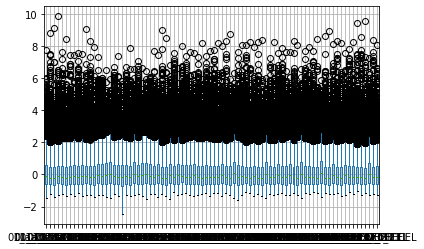

In [13]:
# expression.T.boxplot()
expression_norm.T.boxplot()
# expression_qnorm.T.boxplot()

In [14]:
express_samp = pd.concat([expression_norm, samples], axis=1)

express_samp.head()

,1000_at,1001_at,1002_f_at,1003_s_at,1004_at,1005_at,1006_at,1007_s_at,1008_f_at,1009_at,...,AFFX-YEL002c/WBP1_at,AFFX-YEL018w/_at,AFFX-YEL021w/URA3_at,AFFX-YEL024w/RIP1_at,AFFX-hum_alu_at,patient,sex,region,lab,chip.version
01_a_D_f_2.CEL,2.196509,-0.151815,-0.615233,0.177380,0.159877,0.560659,-0.748829,1.937872,1.477628,0.798767,...,-0.667471,-0.660811,-0.820457,-0.632232,7.729217,patient_01,female,A.C. cortex,Davis,v2
01_a_I_f_2.CEL,1.999970,-0.197477,-0.528449,0.281644,0.036265,0.383408,-0.653057,1.477688,2.856317,0.385453,...,-0.775854,-0.682695,-0.493812,-0.620157,8.797598,patient_01,female,A.C. cortex,Irvine,v2
01_a_M_f_1.CEL,1.433169,-0.556803,-0.897108,0.393112,0.200259,0.097877,-0.813018,0.649509,1.981607,0.501014,...,-0.793777,-0.589759,-0.528136,-0.527779,9.122850,patient_01,female,A.C. cortex,Michigan,v1
01_c_D_f_1.CEL,0.828729,-0.620136,-0.815758,-0.093029,0.066129,-0.152688,-0.763286,1.015741,2.773636,2.123867,...,-0.748197,-0.743402,0.052508,-0.596150,9.854697,patient_01,female,cerebellum,Davis,v1
01_c_I_f_2.CEL,1.833375,-0.107206,-0.643162,0.318476,-0.010529,0.839633,-0.585981,1.642639,2.849017,0.817104,...,-0.659499,-0.780506,-0.021548,-0.647630,7.653381,patient_01,female,cerebellum,Irvine,v2


In [15]:
express_samp_UM = express_samp[express_samp.lab == "Michigan"]

p_values = pd.DataFrame()

# for each tissue, permute the 10 outcomes, 
# use the difference-in-means as the test statistic
for tissue in express_samp_UM["region"].unique():
  print(tissue)
  express_samp_UM_new = express_samp_UM[(express_samp_UM.region == tissue)]
  express_samp_UM_new = pd.concat([express_samp_UM_new, pd.DataFrame(columns=['perm'])], axis=1)

  df_male = express_samp_UM_new[express_samp_UM_new.sex == "male"]
  df_female = express_samp_UM_new[express_samp_UM_new.sex == "female"]

  male_mean = df_male.mean()
  female_mean = df_female.mean()

  diff = pd.DataFrame(male_mean - female_mean)
  for comb in combinations(range(10), 5):
    #print(comb)
    express_samp_UM_new.perm = [0] * 10

    express_samp_UM_new.perm.iloc[list(comb)] = 1

    df_male = express_samp_UM_new[express_samp_UM_new.perm == 1]
    df_female = express_samp_UM_new[express_samp_UM_new.perm == 0]

    male_mean = df_male.mean()
    female_mean = df_female.mean()

    diff = pd.concat([diff, male_mean - female_mean], axis=1)
    #print(diff.shape)
  
  # compare columns and get p-values
  diff = diff.abs()
  for j in range(252):
    diff.iloc[:,j+1] = diff.iloc[:,0] <= diff.iloc[:,j+1]
  p_values = pd.concat([p_values, diff.iloc[:,1:].mean(axis=1)], axis=1)

p_values.head()
p_values = p_values.drop(labels=['perm'], axis=0)

A.C. cortex


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3

cerebellum
D.L.P.F. cortex


In [16]:
print(sum(p_values.mean(axis=1) <= 0.05))
print(1/252)
p_values[p_values.mean(axis=1) <= 0.2]
p_values[p_values.min(axis=1) <= 0.008]

8
0.003968253968253968


,0,0,0
1164_at,0.817460,0.007937,0.563492
1231_at,0.388889,0.007937,0.912698
1255_g_at,0.007937,0.920635,0.571429
1365_at,0.158730,0.007937,0.904762
1600_at,0.841270,0.007937,0.166667
...,...,...,...
41735_at,0.507937,0.007937,0.563492
690_s_at,0.857143,0.777778,0.007937
801_at,0.007937,0.436508,0.761905
969_s_at,0.015873,0.007937,0.023810


In [17]:
bonferr = multipletests(p_values.iloc[:,0], method='fdr_bh')[0]
sum(bonferr)

0

In [18]:
p_values.columns = ['A.C. cortex', 'cerebellum', 'D.L.P.F. cortex']
p_values_mean = pd.concat([p_values, pd.DataFrame(p_values.mean(axis=1), columns=['mean'])], axis=1)
p_values_mean.head()

,A.C. cortex,cerebellum,D.L.P.F. cortex,mean
1000_at,0.785714,0.055556,0.944444,0.595238
1001_at,0.333333,0.650794,0.753968,0.579365
1002_f_at,0.365079,0.301587,0.492063,0.386243
1003_s_at,0.507937,0.642857,0.984127,0.711640
1004_at,0.103175,0.396825,0.801587,0.433862


In [19]:
p_values_mean[p_values.min(axis=1) <= 0.008].sort_values(by=['mean'], axis=0)

,A.C. cortex,cerebellum,D.L.P.F. cortex,mean
41214_at,0.007937,0.007937,0.007937,0.007937
38355_at,0.007937,0.007937,0.007937,0.007937
36321_at,0.007937,0.023810,0.015873,0.015873
969_s_at,0.015873,0.007937,0.023810,0.015873
37583_at,0.007937,0.007937,0.055556,0.023810
...,...,...,...,...
33722_at,0.007937,0.960317,0.690476,0.552910
40719_at,0.007937,0.865079,0.793651,0.555556
37455_at,0.007937,0.976190,0.714286,0.566138
34433_at,0.007937,0.904762,0.809524,0.574074


In [20]:
genes.loc[p_values_mean[p_values.min(axis=1) <= 0.008].sort_values(by=['mean'], axis=0).index].loc[:, ['sym','chrom']]

,sym,chrom
41214_at,RPS4Y1,Y
38355_at,DDX3Y,Y
36321_at,TTTY15,Y
969_s_at,NaN,X
37583_at,KDM5D,Y
...,...,...
33722_at,ATRN,20
40719_at,TRAF3IP3,1
37455_at,CXCR5,11
34433_at,DOK1,2


In [21]:
genes.loc[p_values[p_values.mean(axis=1) <= 0.1].index].loc[:, ['sym','chrom']]

,sym,chrom
32964_at,EMR1,19
35095_r_at,LILRA3,19
35797_at,IL13RA1,X
35885_at,USP9Y,Y
36321_at,TTTY15,Y
37583_at,KDM5D,Y
38182_at,CYorf15B,Y
38355_at,DDX3Y,Y
38446_at,XIST,X
38585_at,NaN,11hbg
